# Sea Surface Height — NEMO GYRE

Analyse SSH (`sossheig`) from the 2-year GYRE simulation.
- Temporal variance (spatial map)
- Domain-mean SSH time series

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

OUTPUT_DIR = Path("../output")
ds = xr.open_dataset(
    OUTPUT_DIR / "GYRE_10d_00010101_00021230_grid_T_0000.nc", decode_times=False
)
mask = xr.open_dataset(OUTPUT_DIR / "mesh_mask.nc")
tmask_sfc = mask["tmask"].isel(time_counter=0, nav_lev=0).values  # (y, x)

# Exclude outermost ring (boundary condition cells)
interior = tmask_sfc.copy()
interior[0, :] = 0
interior[-1, :] = 0
interior[:, 0] = 0
interior[:, -1] = 0

# Map projection centred on the GYRE domain
MARGIN = 8
lon, lat = ds.nav_lon.values, ds.nav_lat.values
proj = ccrs.Stereographic(central_longitude=-68, central_latitude=32)
extent = [lon.min() - MARGIN, lon.max() + MARGIN,
          lat.min() - MARGIN, lat.max() + MARGIN]

ssh = ds["sossheig"]
ssh

<xarray.DataArray 'sossheig' (time_counter: 72, y: 22, x: 32)> Size: 203kB
[50688 values with dtype=float32]
Coordinates:
  * time_counter  (time_counter) float64 576B 4.32e+05 1.296e+06 ... 6.178e+07
    nav_lon       (y, x) float32 3kB -71.52 -70.85 -70.17 ... -65.45 -64.78
    nav_lat       (y, x) float32 3kB 14.85 15.52 16.19 ... 48.55 49.22 49.9
Dimensions without coordinates: y, x
Attributes:
    units:               m
    standard_name:       Sea Surface Height
    long_name:           Sea Surface Height
    online_operation:    ave(x)
    interval_operation:  14400.0
    interval_write:      864000.0

## SSH temporal variance

Variance over time at each grid point — highlights regions with the most
sea-level variability (western boundary current).

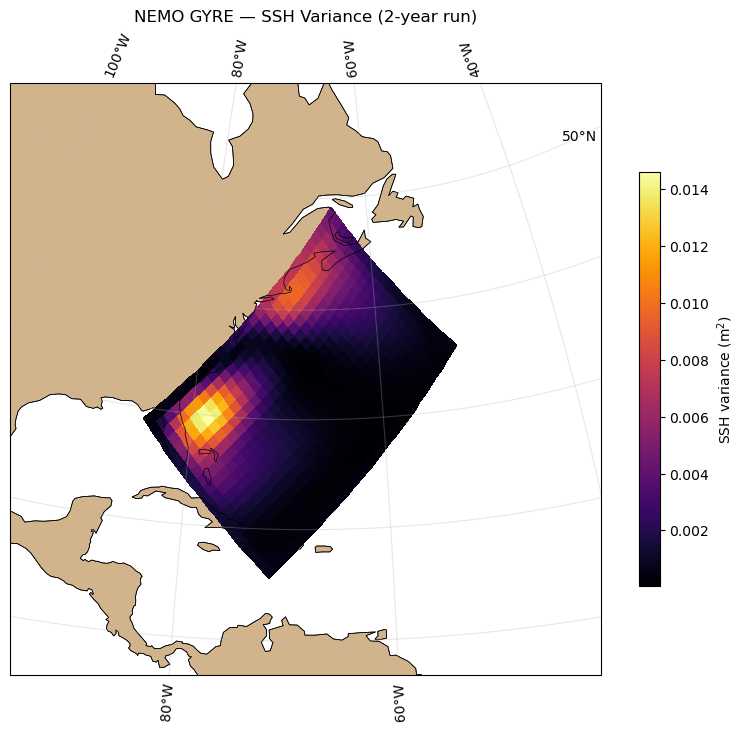

In [2]:
ssh_var = ssh.var("time_counter")
ssh_var_masked = np.where(interior, ssh_var.values, np.nan)

fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(projection=proj))
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor="tan", edgecolor="k", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.gridlines(draw_labels=True, alpha=0.3)

pcm = ax.pcolormesh(
    lon, lat, ssh_var_masked,
    shading="auto", cmap="inferno", transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="SSH variance (m$^2$)", shrink=0.7)
ax.set_title("NEMO GYRE — SSH Variance (2-year run)")
fig.tight_layout()

## Domain-mean SSH time series

Area-averaged SSH over time. With `key_linssh` (linear free surface) the
domain volume is conserved exactly, so the domain-mean SSH stays near
zero — any signal here is numerical noise at machine precision (~1e-9 m).

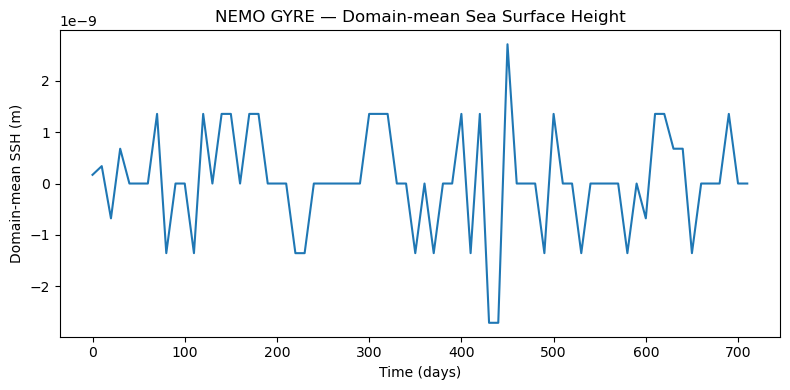

In [3]:
ssh_mean = ssh.mean(dim=["x", "y"])
time_days = (ds.time_counter.values - ds.time_counter.values[0]) / 86400.0

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time_days, ssh_mean.values)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Domain-mean SSH (m)")
ax.set_title("NEMO GYRE — Domain-mean Sea Surface Height")
fig.tight_layout()